# Логистическая регрессия

**Цель: Создать модель классификации для предcказания того, есть ли у пациента признаки болезни сердца, в зависимости от физических характеристик этого человека (возраст, пол, холистерол и т.д.)**



## Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB # Байес
from sklearn.tree import DecisionTreeClassifier # Дерево решений
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV # Лог. регрессия
from sklearn.neighbors import KNeighborsClassifier # К-ближайших соседей
from sklearn.svm import SVC # Опорные вектора

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

from warnings import filterwarnings
filterwarnings('ignore')

sns.set_style('darkgrid')

## Данные

В базе данных содержатся 14 атрибутов о физическом тестировании пациентов. Они сдают кровь и выполняют небольшой физический тест. Колонка "goal" указывает на наличие заболевания сердца у пациента - 0 означает заболевания нет, 1 означает заболевание есть. В общем случае, подтвердить на 100% заболевание сердца это очень инвазивный процесс, поэтому если мы сможем построить модель, которая достаточно точно оценивает вероятность заболевания, то это поможет избежать дорогих инвазивных процедур.

Содержимое

Информация об атрибутах:

* age - возраст
* sex - пол
* cp - chest pain - тип боли в груди (4 значения)
* trestbps - resting blood pressure - давление в состоянии покоя
* chol - уровень холистерина в крови, в mg/dl
* fbs - fasting blood sugar - уровень сахара в крови, > 120 mg/dl
* restecg - resting electrocardiographic results - результаты электрокардиограммы (значения 0,1,2)
* thalach - максимальный пульс
* exang - exercise induced angina - возникновение ангины в результате упражнений
* oldpeak - пиковые значения в электрокардиограмме, как результат упражнений (по сравнению с состоянием покоя)
* slope - наклон пикового значения в электрокардиограмме, как результат упражнений (по сравнению с состоянием покоя)
* ca - количество крупных сосудов (0-3), окрашенных флурозопией
* thal -  0 = нормально; 1 = фиксированный дефект; 2 = обратимый дефект
* target - 0 означает отсутствие заболевания сердца, 1 означает наличие заболевания сердца

Источник: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [2]:
df = pd.read_csv('heart.csv')

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df['target'].unique()

array([1, 0], dtype=int64)

### Анализ данных и визуализация данных

In [5]:
# Пропущенные значения
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [7]:
# Статистические показатели
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [8]:
# Дубликаты в данных
df[df.duplicated()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [9]:
df[df['age'] == 38]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
259,38,1,3,120,231,0,1,182,1,3.8,1,0,3,0


In [10]:
# Удаляем дубликаты
df.drop(index = 163, inplace=True)

### Выбросы

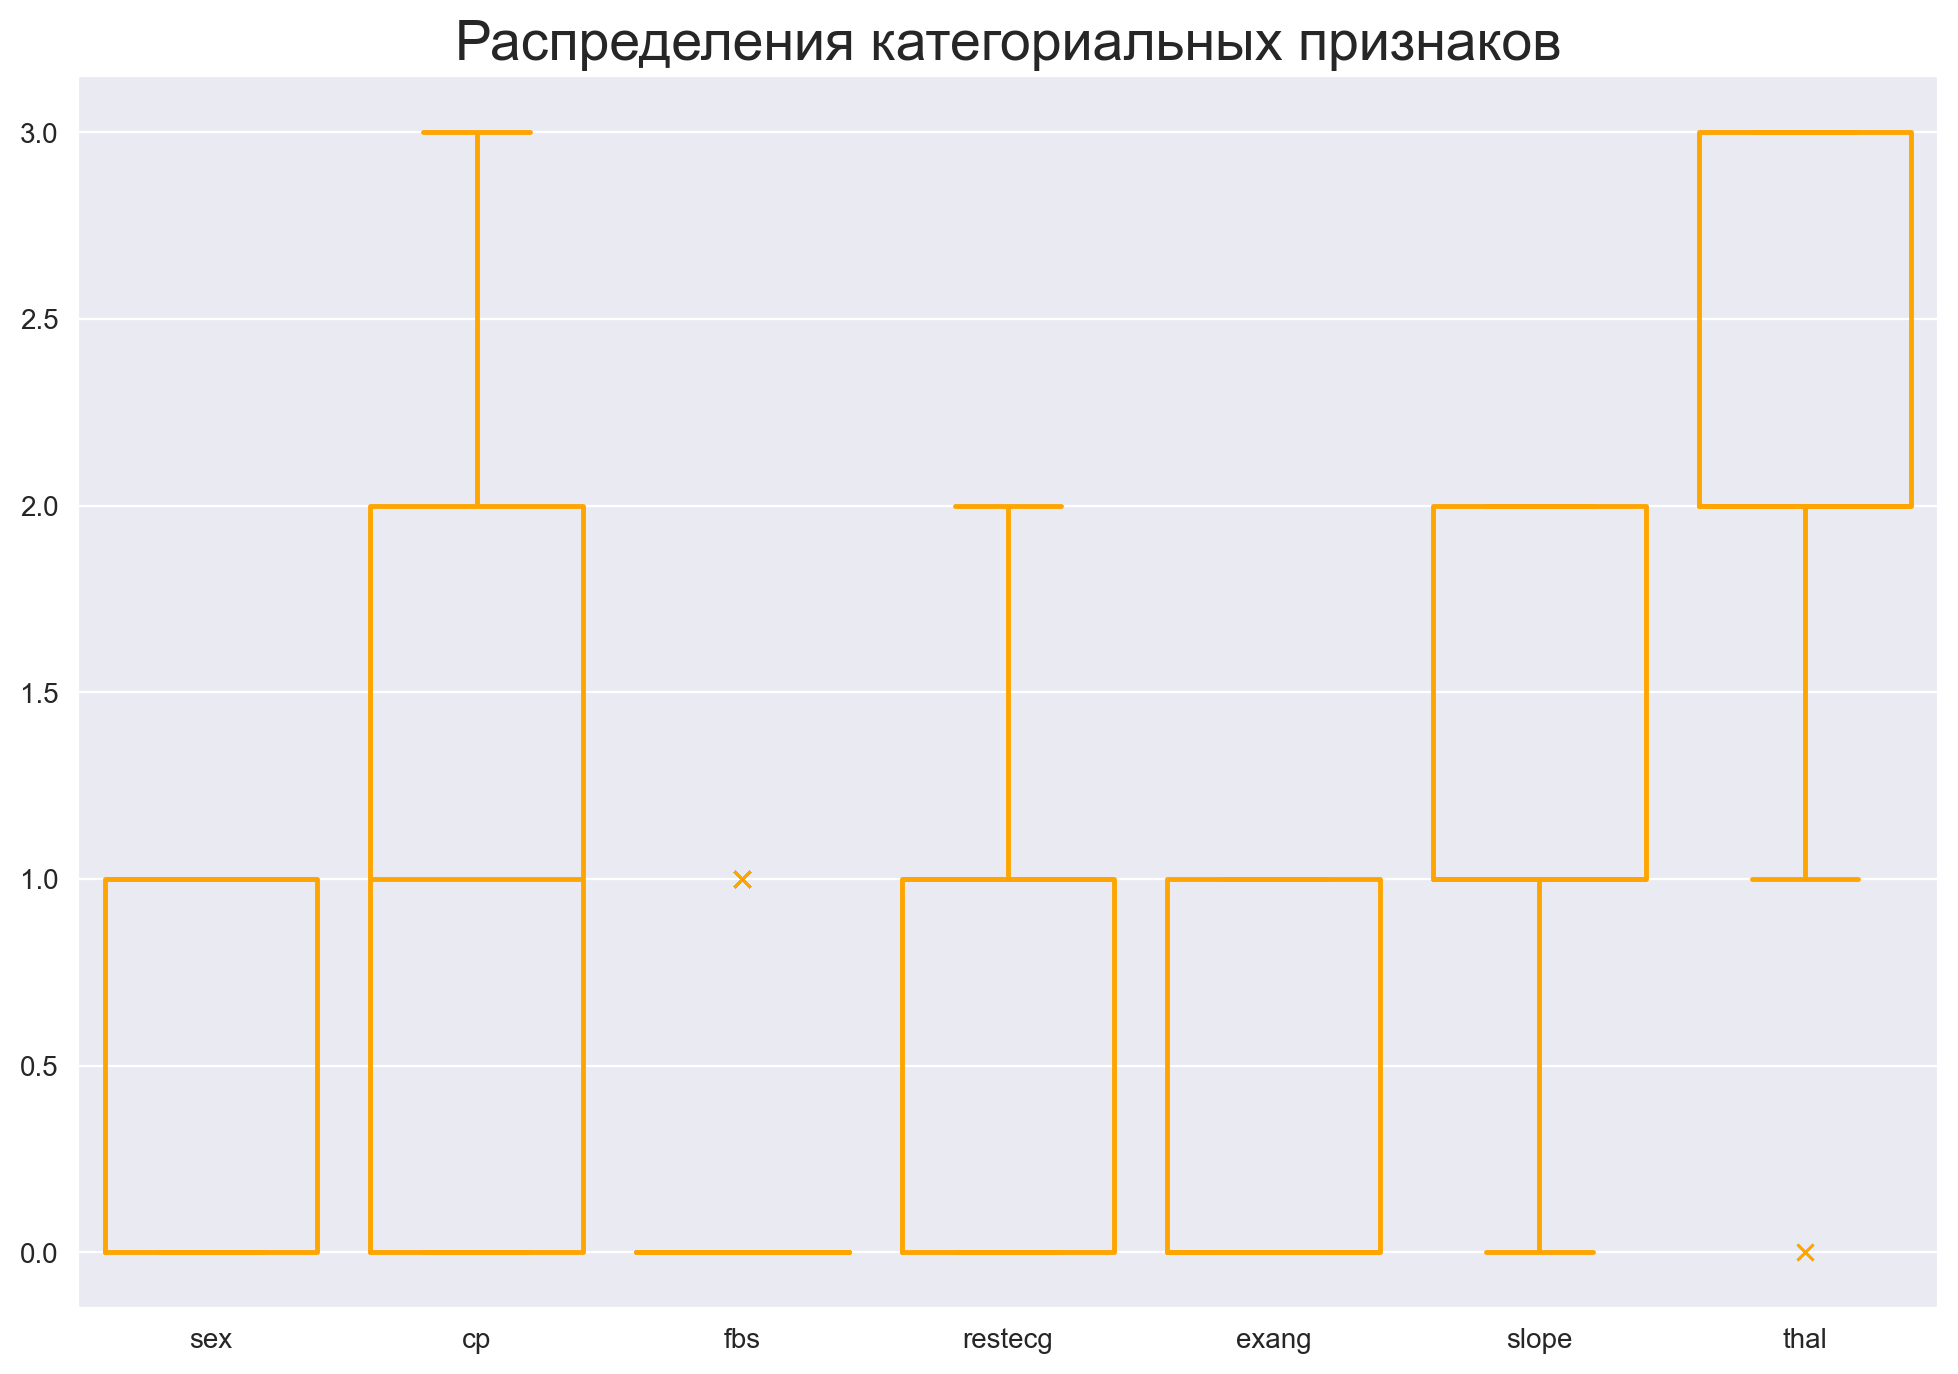

In [11]:
plt.figure(figsize=(12,8),dpi=200)
sns.boxplot(data=df.drop(['trestbps', 'chol', 'thalach', 'age', 'target', 'oldpeak', 'ca'], axis=1), fill=False, color='orange', linewidth=1.75,
           flierprops={"marker": "x"})
plt.title('Распределения категориальных признаков', fontsize=20);

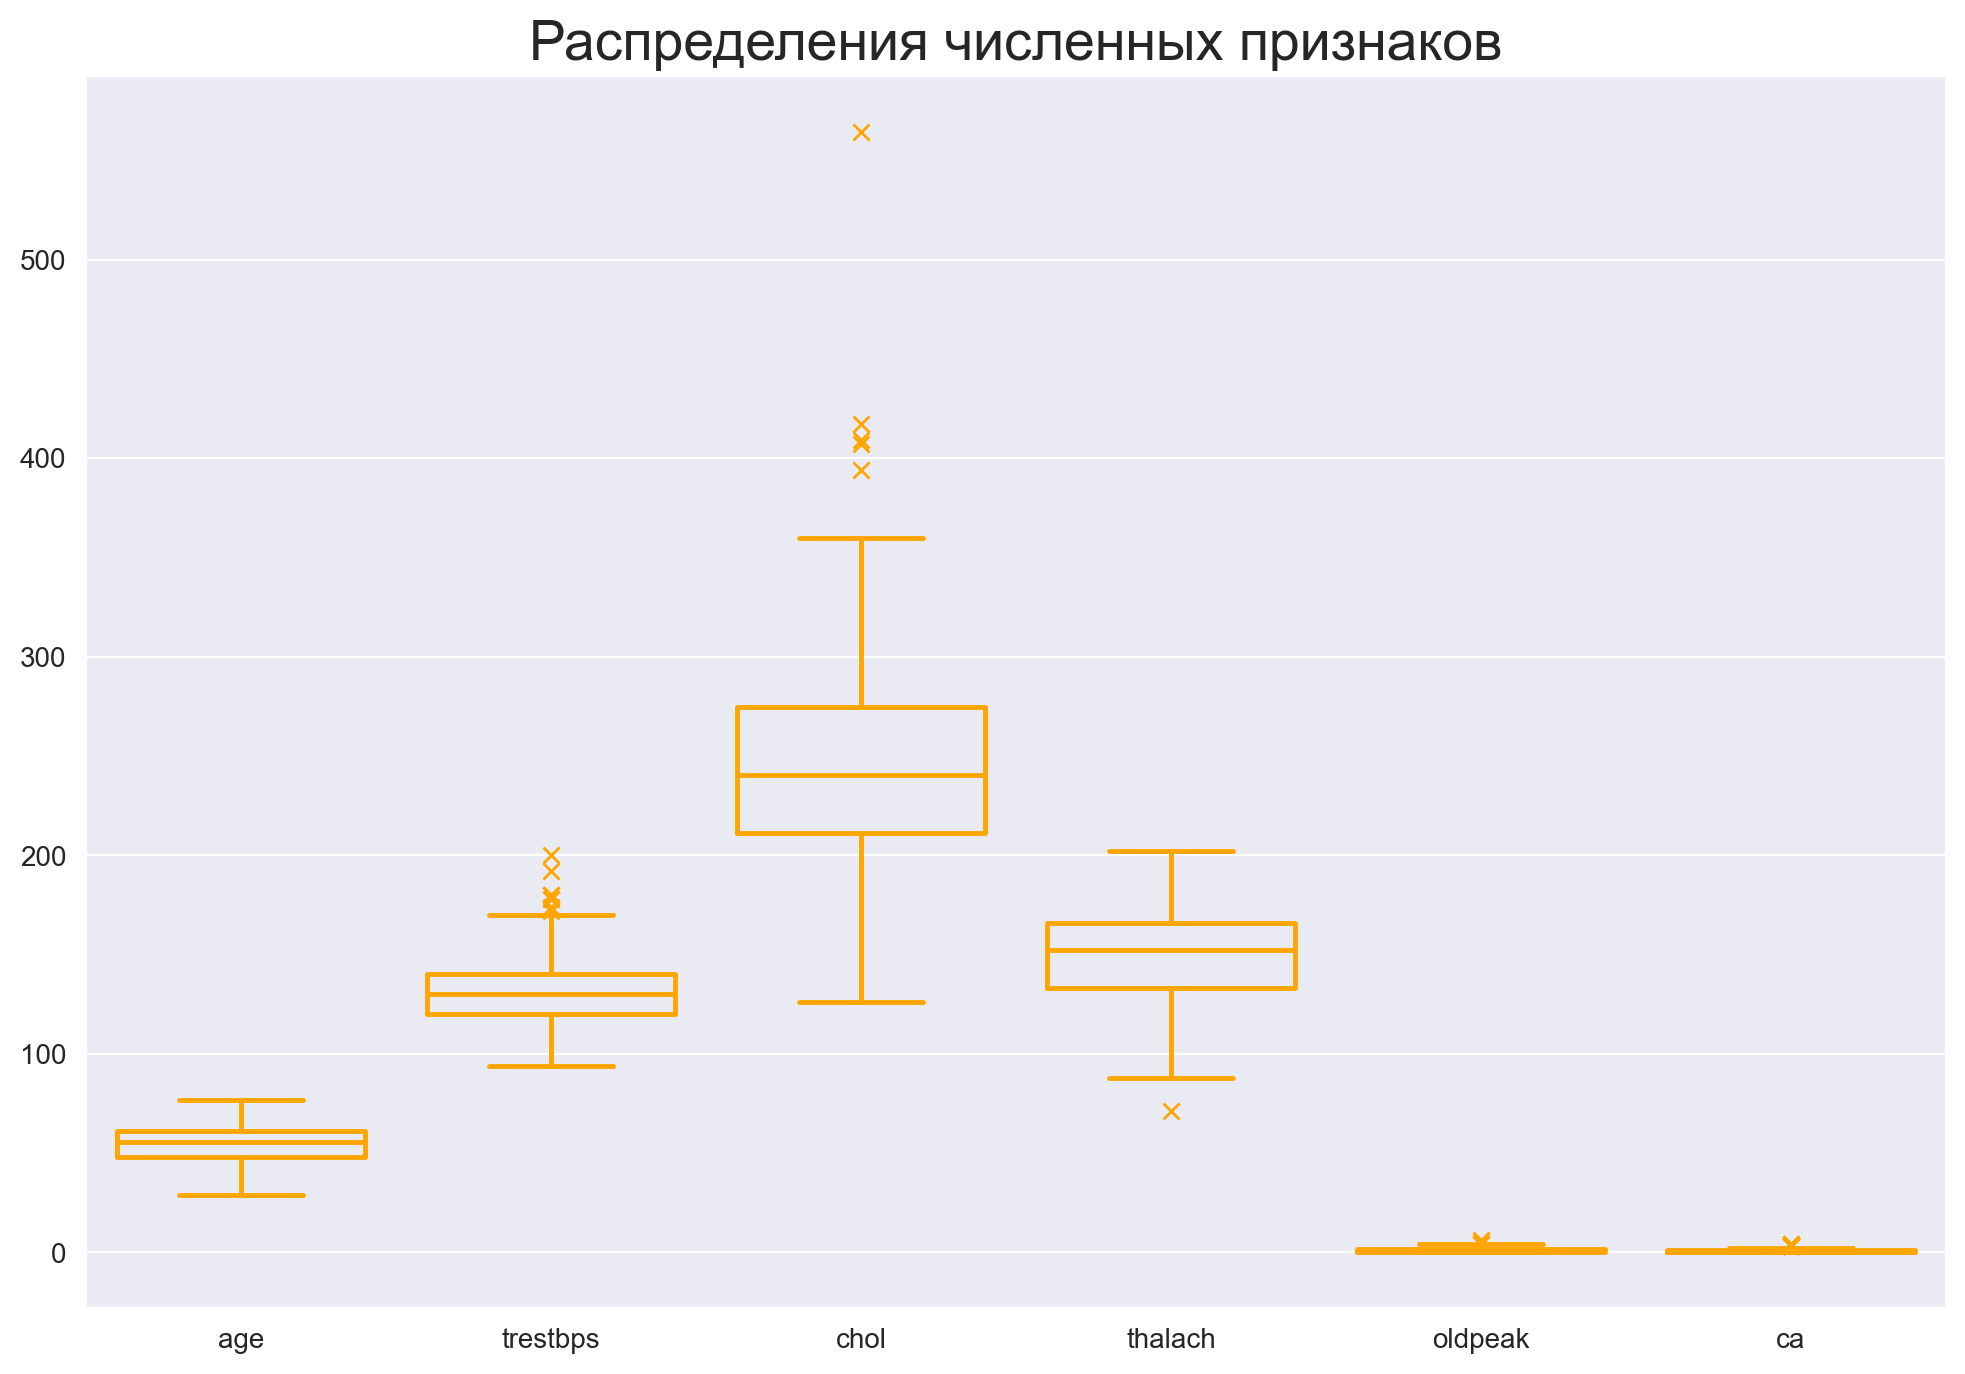

In [12]:
plt.figure(figsize=(12,8),dpi=200)
sns.boxplot(data=df.drop(['sex', 'cp', 'fbs', 'restecg', 'target', 'exang', 'slope', 'thal'], axis=1), fill=False, color='orange', linewidth=1.75,
           flierprops={"marker": "x"})
plt.title('Распределения численных признаков', fontsize=20);

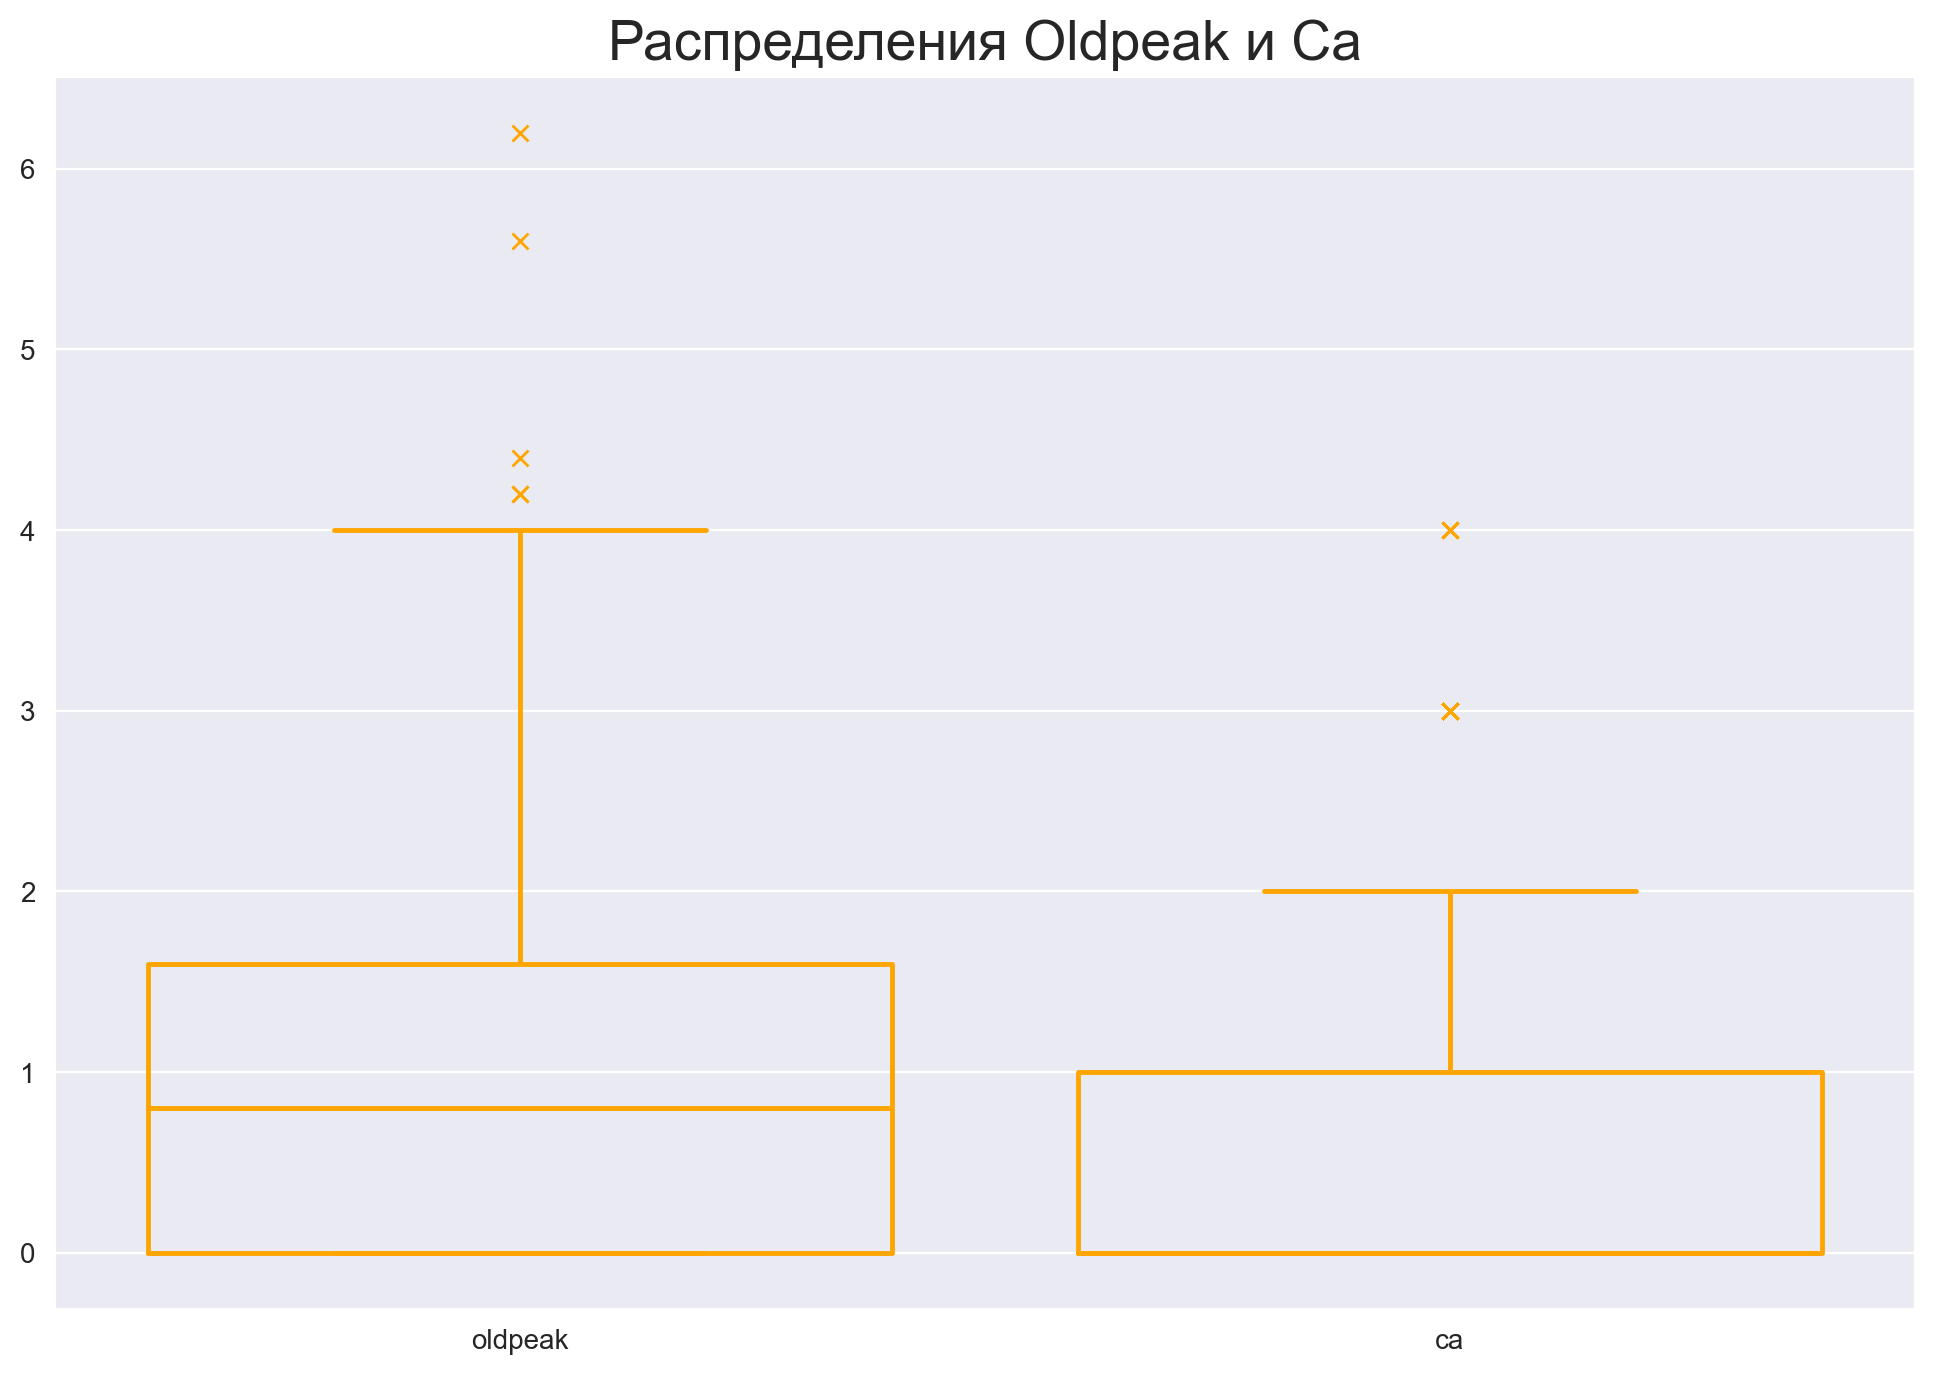

In [13]:
plt.figure(figsize=(12,8),dpi=200)
sns.boxplot(data=df.drop(['sex', 'cp', 'fbs', 'restecg', 'target', 'exang', 'slope', 'thal', 'age', 'trestbps', 'chol', 'thalach'], axis=1), fill=False, color='orange', linewidth=1.75,
           flierprops={"marker": "x"})
plt.title('Распределения Oldpeak и Ca', fontsize=20);

### Обработка выбросов в численных столбцах

In [14]:
for col in ['trestbps', 'chol', 'thalach', 'age', 'oldpeak', 'ca']:
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mean = df[(df[col] <= upper_bound) & (df[col] >= lower_bound)][col].mean()
    df[col] = df[col].mask(df[col] > upper_bound, mean)
    df[col] = df[col].mask(df[col] < lower_bound, mean)

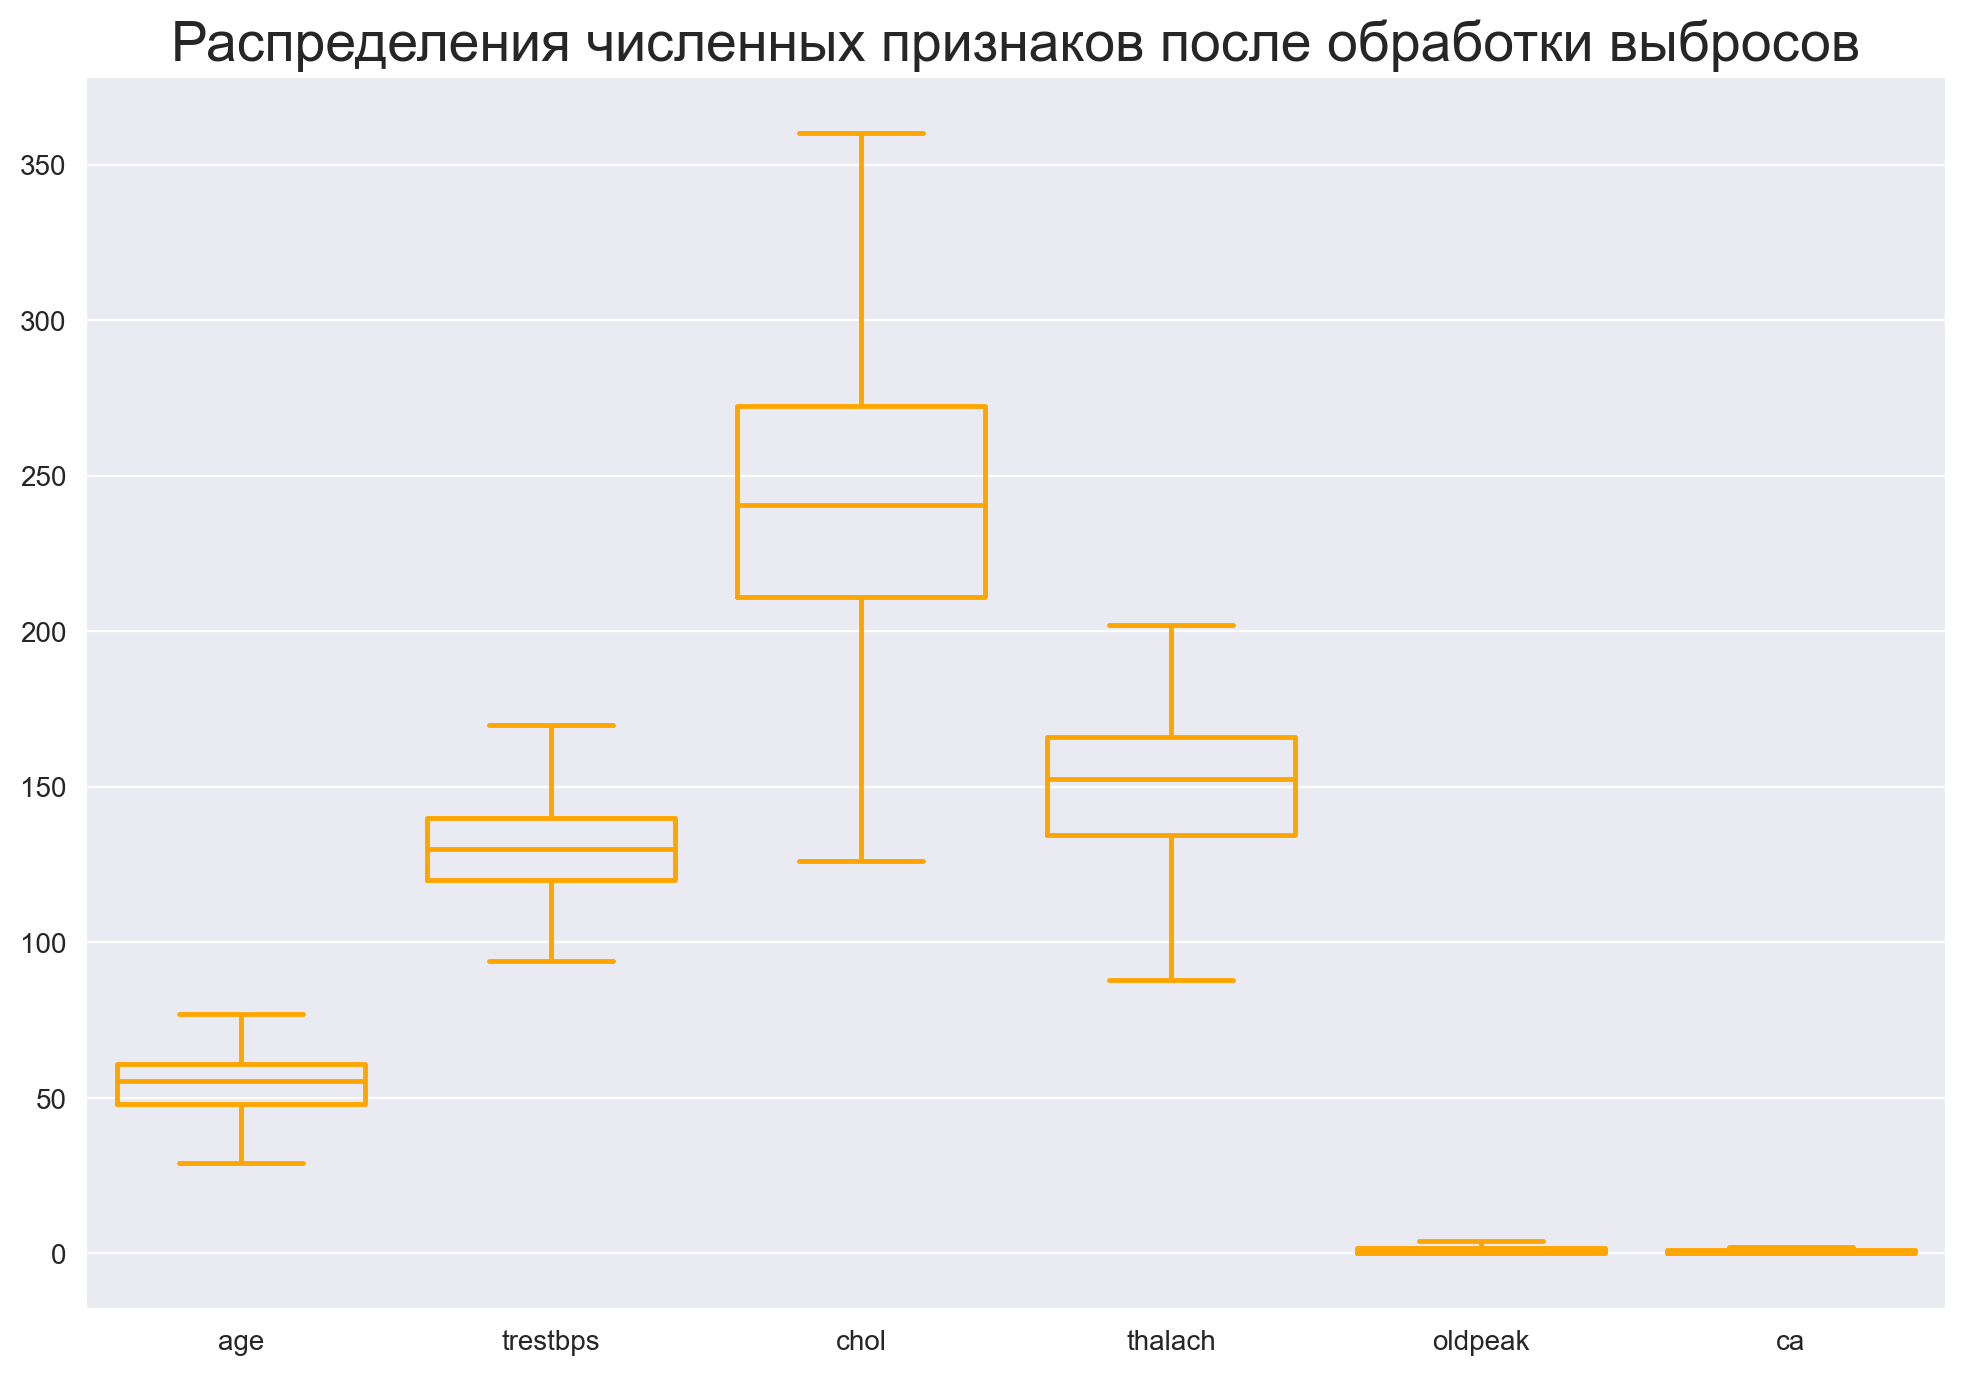

In [15]:
plt.figure(figsize=(12,8),dpi=200)
sns.boxplot(data=df.drop(['sex', 'cp', 'fbs', 'restecg', 'target', 'exang', 'slope', 'thal'], axis=1), fill=False, color='orange', linewidth=1.75,
           flierprops={"marker": "x"})
plt.title('Распределения численных признаков после обработки выбросов', fontsize=20);

### Визуализация данных

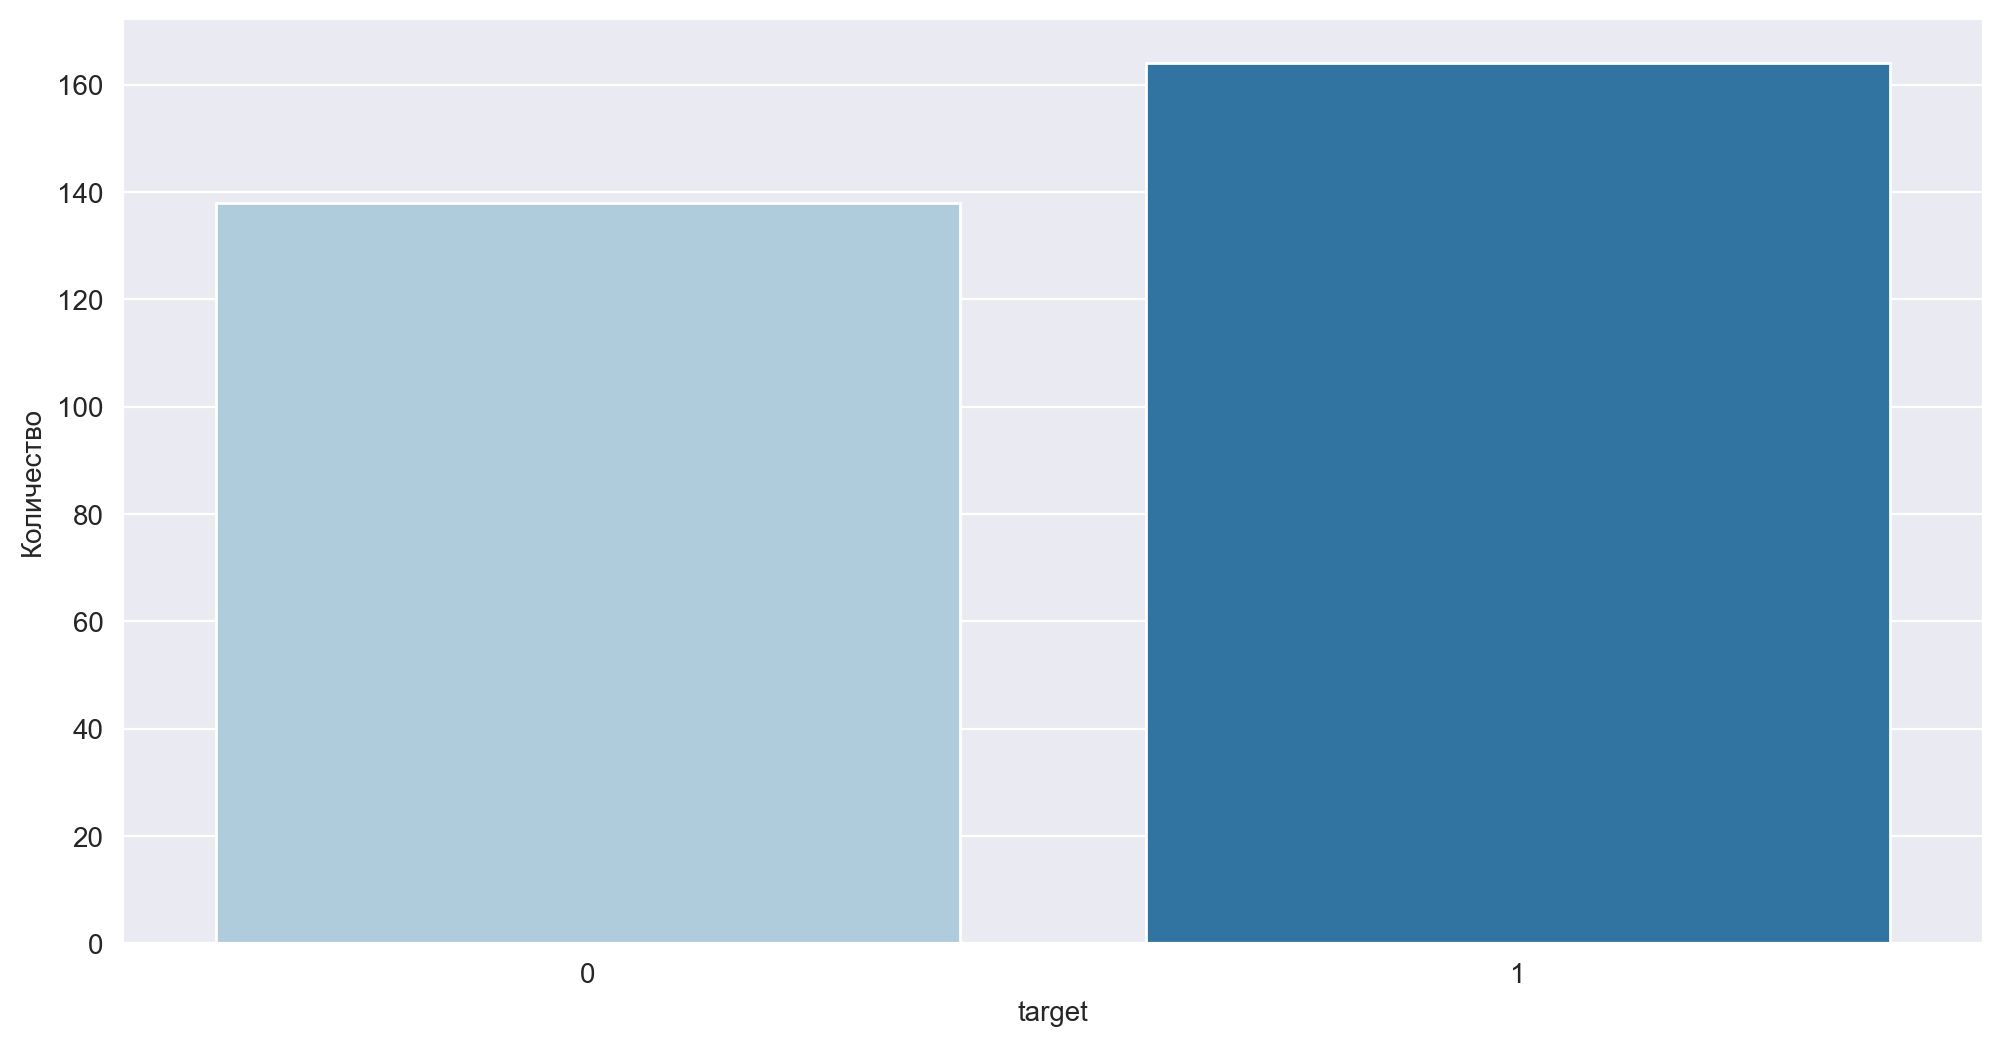

In [16]:
# Подсчёт классов
plt.figure(figsize=(12,6), dpi=200)
sns.countplot(data=df, x='target', palette='Paired');
plt.ylabel('Количество');

**График pairplot, показывающий связи между следующими колонками:**

    ['age','trestbps', 'chol','thalach','target']

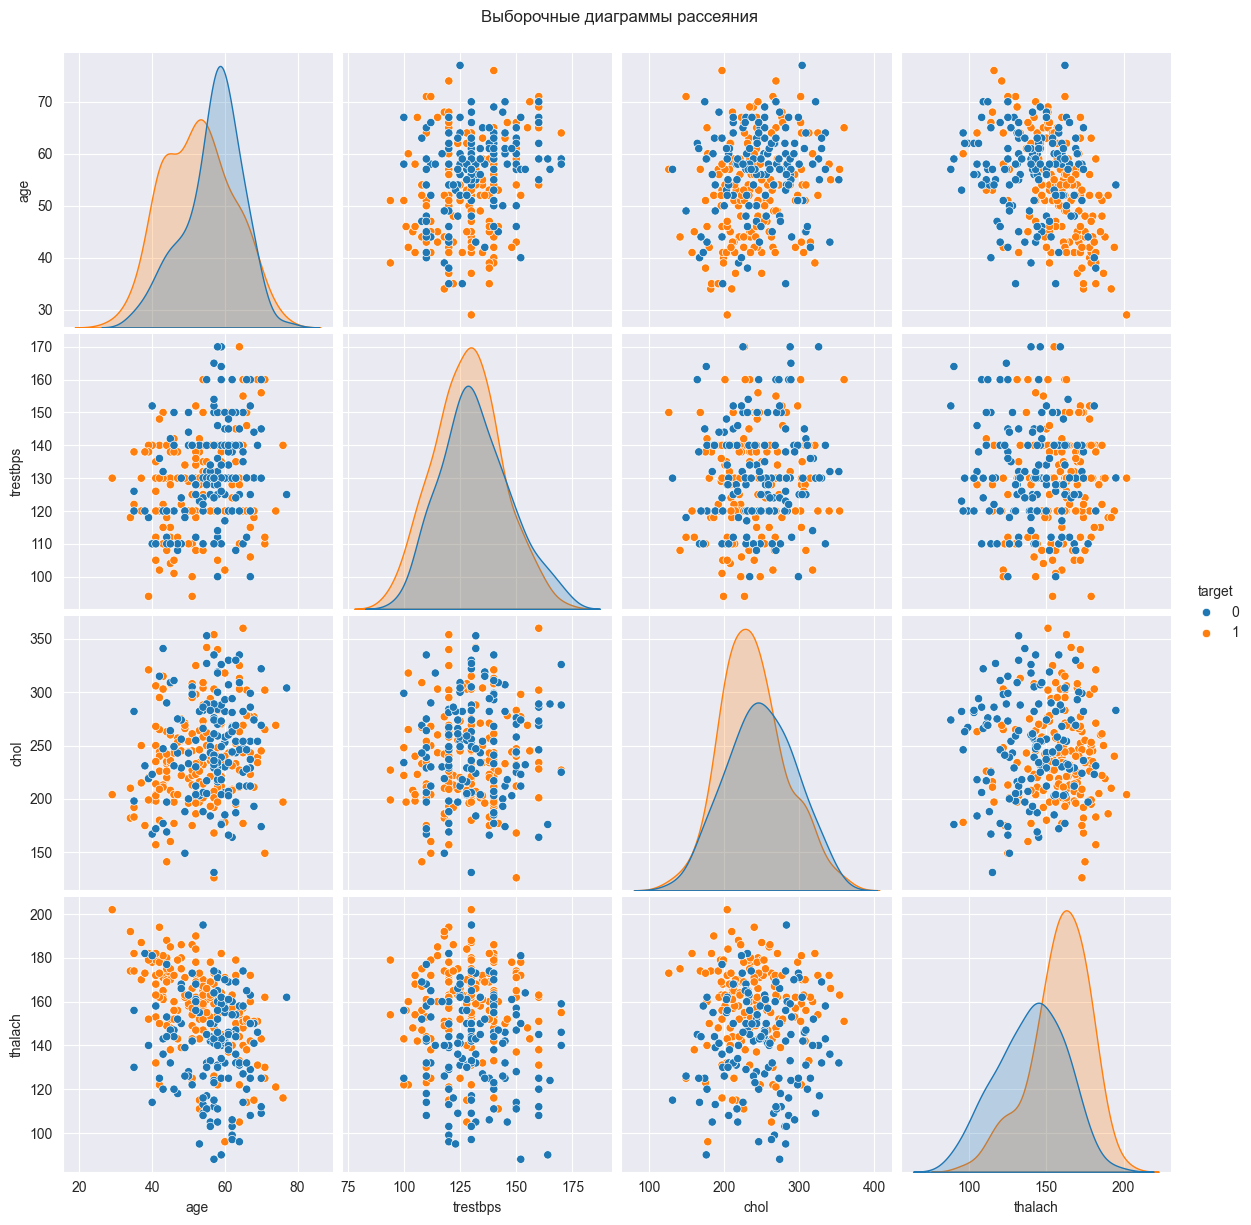

In [17]:
pair_df = df[['age','trestbps', 'chol','thalach','target']]
g = sns.pairplot(data=pair_df, hue='target', size=3);
g.fig.suptitle("Выборочные диаграммы рассеяния", y=1.02);

**Heatmap, показывающий корреляции между всеми колонками.**

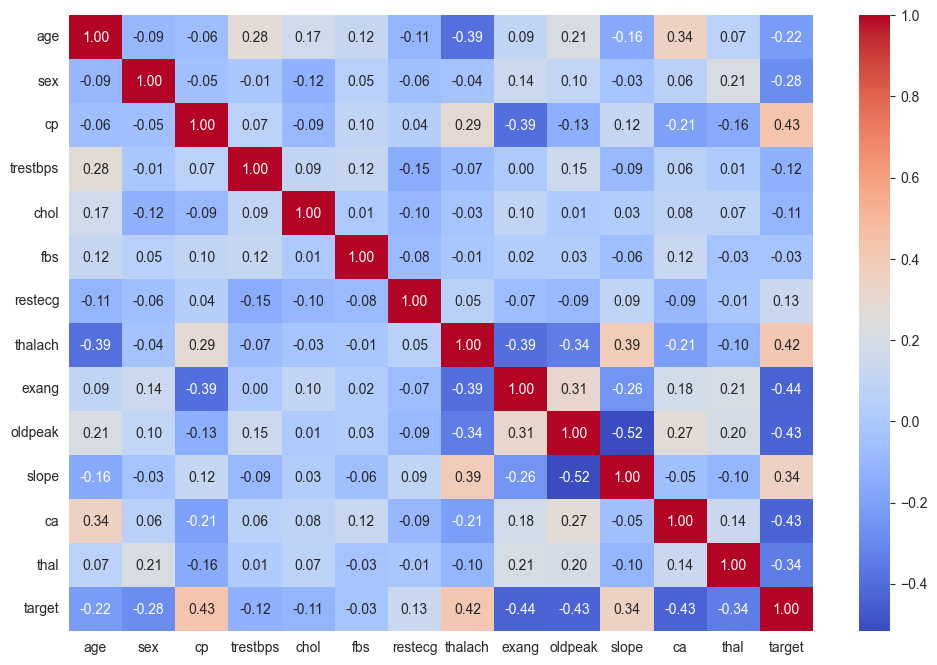

In [18]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', annot_kws={'size':10});

----
----

# Машинное обучение

## Разбиение на обучающий и тестовый наборы данных, а также масштабирование данных

In [19]:
X = df.drop('target', axis=1)
y = df['target']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [21]:
# Использование масштабирования данных
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# Байес

# Дерево решений

### GridSearchCV

In [22]:
log_model = LogisticRegression(max_iter=10000, multi_class='ovr', solver='saga')

In [23]:
l1_ratio = np.linspace(0, 1, 30)
C = [10**i for i in range(-4, 5)]
penalty = ['l1', 'l2', 'elasticnet']
params = {'l1_ratio': l1_ratio, 'C': C, 'penalty': penalty}

In [24]:
grid_model = GridSearchCV(log_model, param_grid=params)
grid_model.fit(X_train_scale, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=10000, multi_class='ovr',
                                          solver='saga'),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000],
                         'l1_ratio': array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
       0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
       0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
       0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
       0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
       0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ]),
                         'penalty': ['l1', 'l2', 'elasticnet']})

### LogisticRegressionCV

In [25]:
l1_ratio = np.linspace(0, 1, 30)
C = np.logspace(-4, 4, num=10)
log_cv_model = LogisticRegressionCV(cv=5, Cs=C,
                                    max_iter=10000, solver='saga', multi_class='ovr')

In [26]:
log_cv_model.fit(X_train_scale, y_train)

LogisticRegressionCV(Cs=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                     cv=5, max_iter=10000, multi_class='ovr', solver='saga')

### Коэффициенты GridSearchCV

In [27]:
# Лучшая модель
grid_model.best_estimator_

LogisticRegression(C=0.1, l1_ratio=0.41379310344827586, max_iter=10000,
                   multi_class='ovr', penalty='elasticnet', solver='saga')

In [28]:
grid_model.best_params_

{'C': 0.1, 'l1_ratio': 0.41379310344827586, 'penalty': 'elasticnet'}

### Коэффициенты LogisticRegressionCV

In [29]:
log_cv_model.coef_

array([[ 0.01820162, -0.72085522,  0.8182793 , -0.26308911, -0.23675036,
         0.07059176,  0.15288585,  0.38411311, -0.3373086 , -0.58008063,
         0.40572272, -0.93795156, -0.59739667]])

In [30]:
log_cv_model.intercept_

array([0.1161871])

**Barplot для признаков LogisticRegressionCV**

In [31]:
# Сортируем признаки по их значениям
coefs = log_cv_model.coef_[0]
columns = X_train.columns
feature_df = pd.DataFrame({'coefs': coefs, 'columns': columns})
feature_df = feature_df.sort_values(by='coefs')
feature_df

,coefs,columns
11,-0.937952,ca
1,-0.720855,sex
12,-0.597397,thal
9,-0.580081,oldpeak
8,-0.337309,exang
3,-0.263089,trestbps
4,-0.236750,chol
0,0.018202,age
5,0.070592,fbs
6,0.152886,restecg


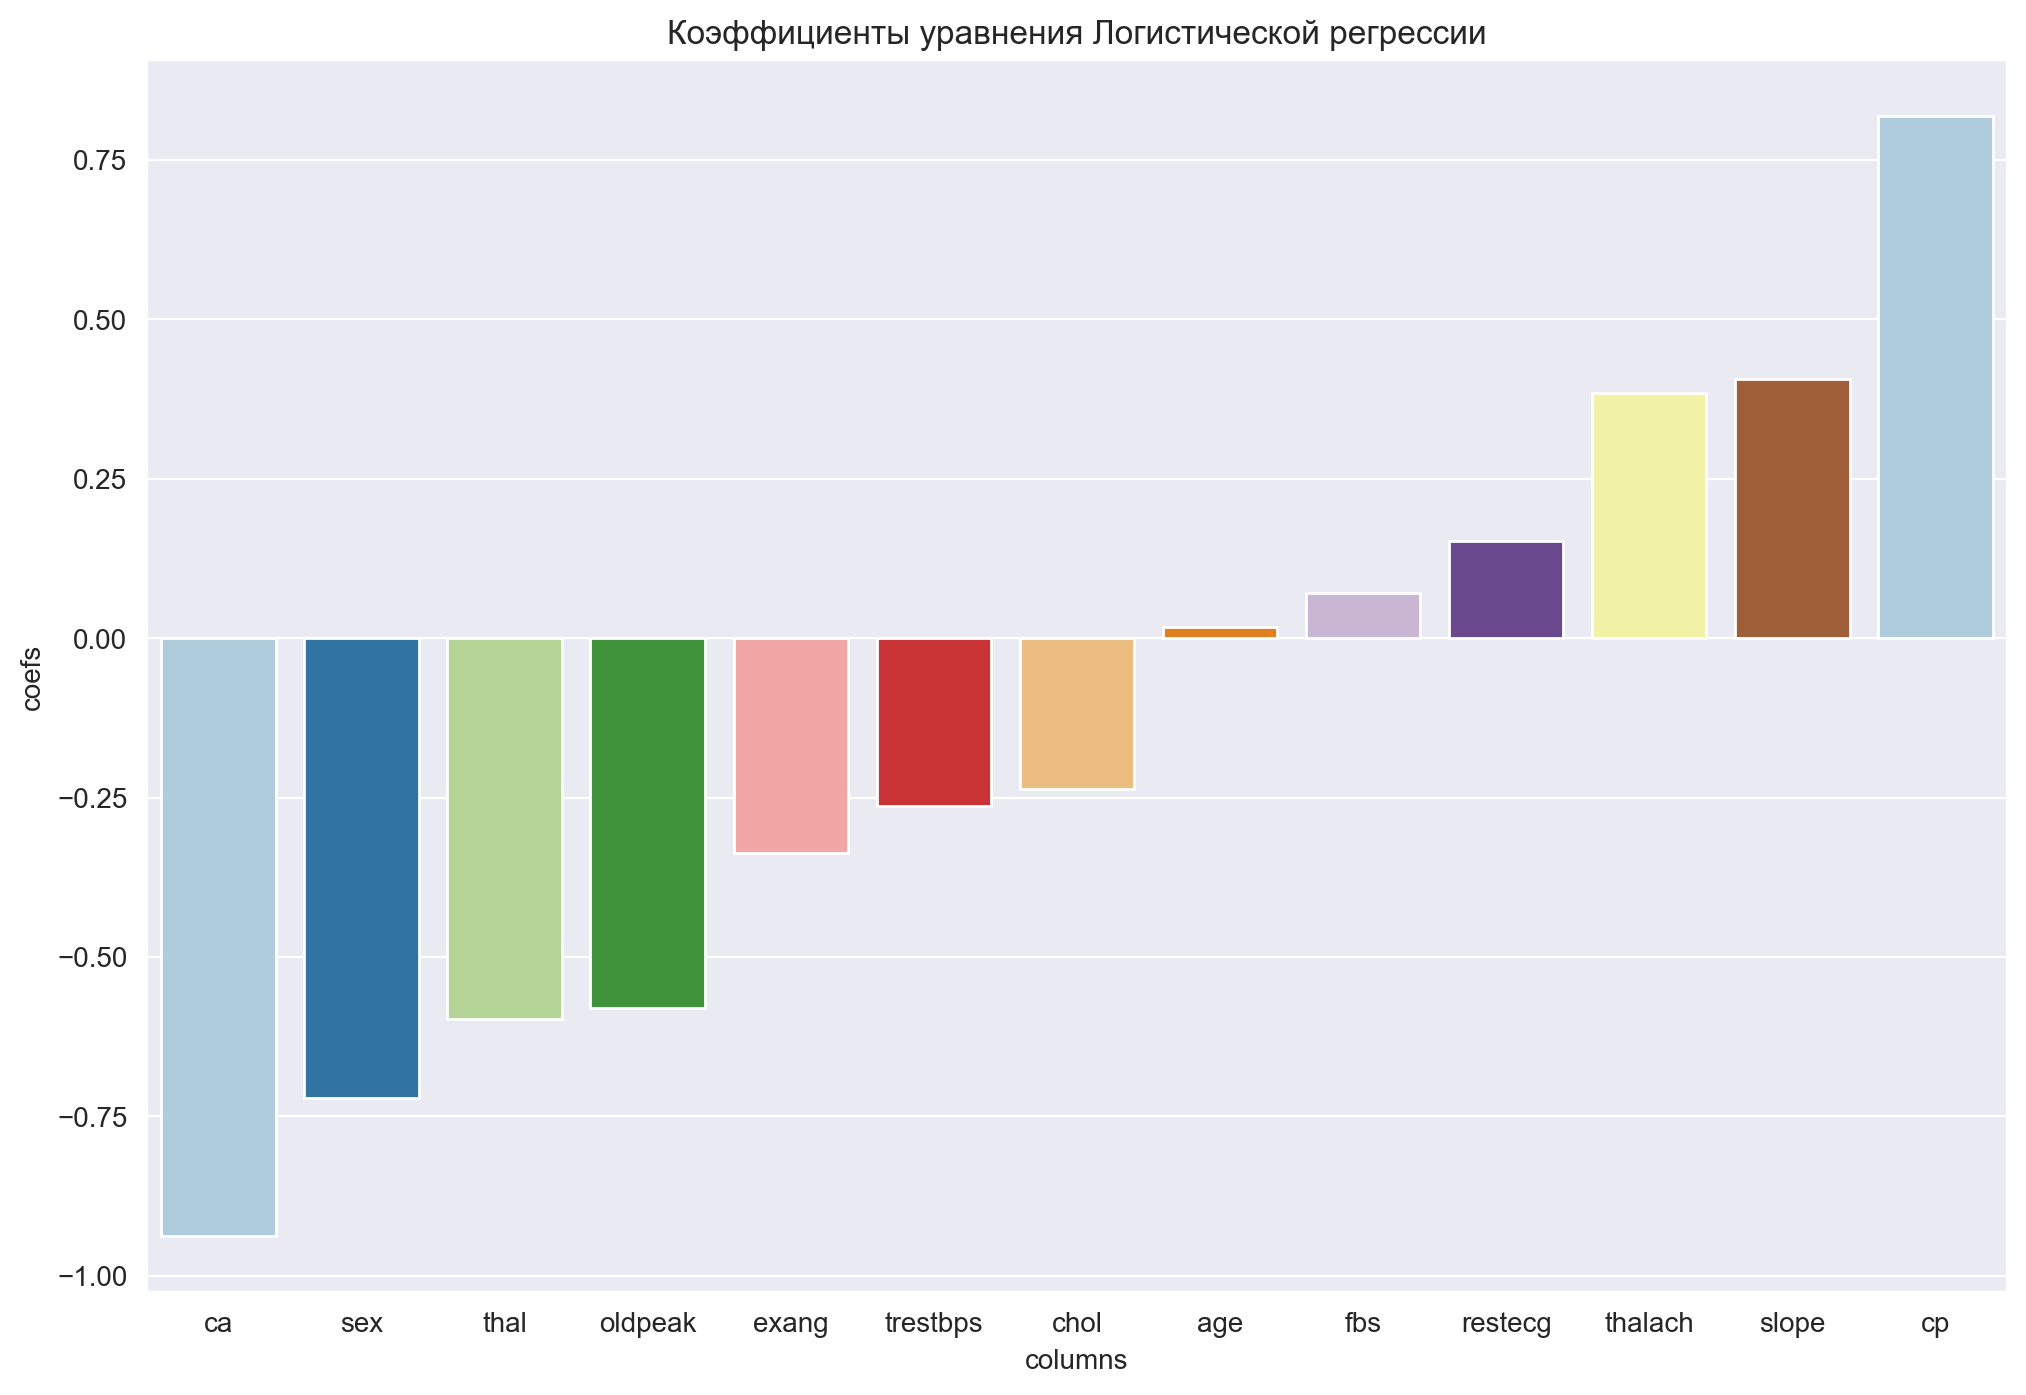

In [32]:
plt.figure(figsize=(12,8), dpi=200)
sns.barplot(x=feature_df['columns'], y=feature_df['coefs'], palette='Paired');
plt.title('Коэффициенты уравнения Логистической регрессии');

# K-ближайших соседей

# SVM

---------

## Оценка моделей

In [33]:
y_grid_pred = grid_model.predict(X_test_scale)
y_cv_pred = log_cv_model.predict(X_test_scale)

**Confusion_matrix**

In [34]:
# GridSearchCV
confusion_matrix(y_test, y_grid_pred)

array([[12,  2],
       [ 1, 16]], dtype=int64)

In [35]:
# LogisticRegressionCV
confusion_matrix(y_test, y_cv_pred)

array([[13,  1],
       [ 1, 16]], dtype=int64)

**Confusion_matrix в виде картинки**

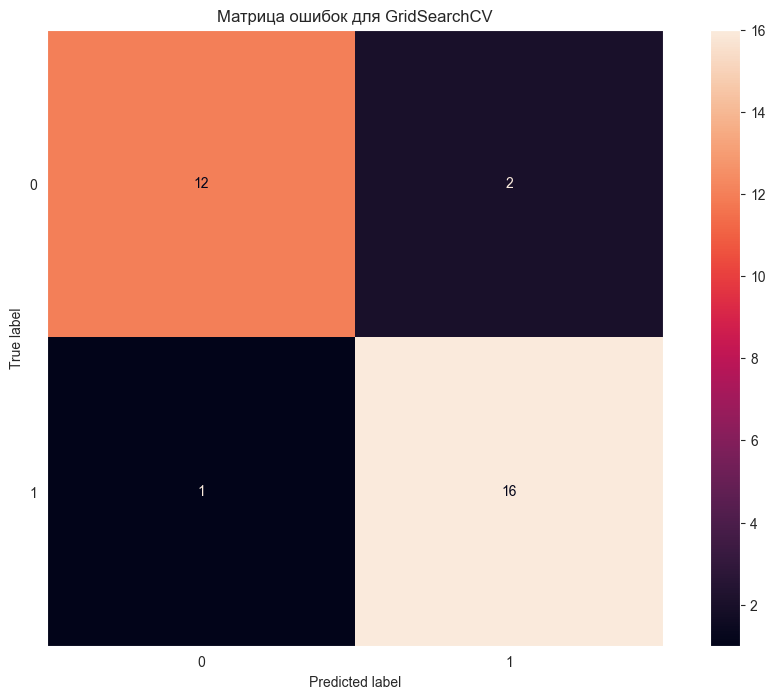

In [36]:
# GridSearchCV
fig, ax = plt.subplots(figsize=(12,8))
ConfusionMatrixDisplay.from_estimator(grid_model, X_test_scale, y_test, cmap='rocket', ax=ax)
plt.grid(False)
plt.title('Матрица ошибок для GridSearchCV');

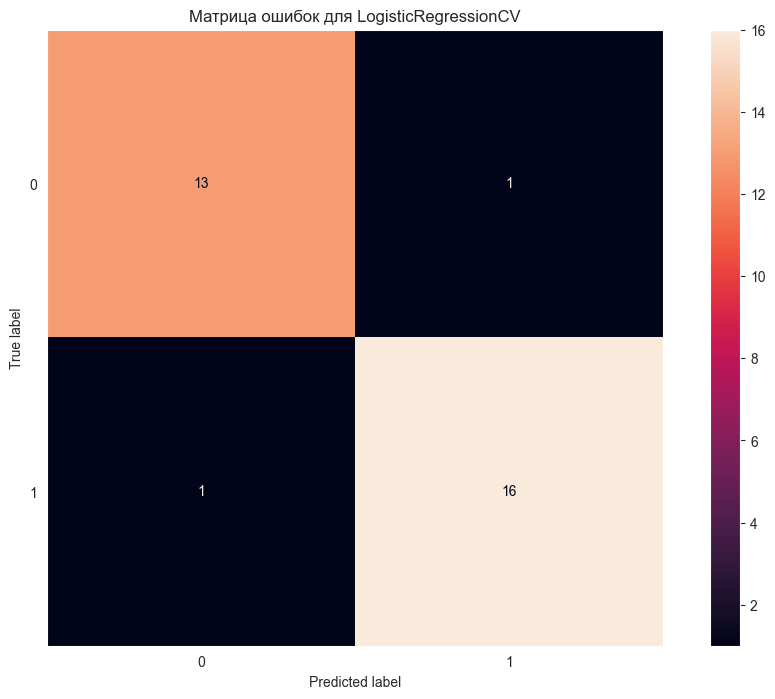

In [37]:
# LogisticRegressionCV
fig, ax = plt.subplots(figsize=(12,8))
ConfusionMatrixDisplay.from_estimator(log_cv_model, X_test_scale, y_test, cmap='rocket', ax=ax)
plt.grid(False)
plt.title('Матрица ошибок для LogisticRegressionCV');

**Метрики классификации**

In [38]:
# GridSearchCV
print(classification_report(y_test, y_grid_pred))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89        14
           1       0.89      0.94      0.91        17

    accuracy                           0.90        31
   macro avg       0.91      0.90      0.90        31
weighted avg       0.90      0.90      0.90        31



In [39]:
# LogisticRegressionCV
print(classification_report(y_test, y_cv_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.94      0.94      0.94        17

    accuracy                           0.94        31
   macro avg       0.93      0.93      0.93        31
weighted avg       0.94      0.94      0.94        31



### Кривые производительности для GridSearchCV

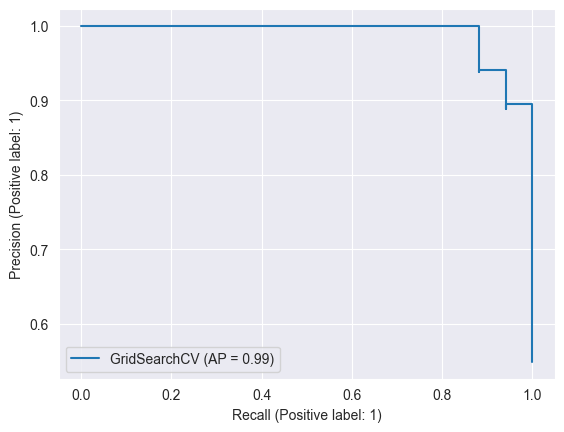

In [40]:
PrecisionRecallDisplay.from_estimator(grid_model, X_test_scale, y_test);

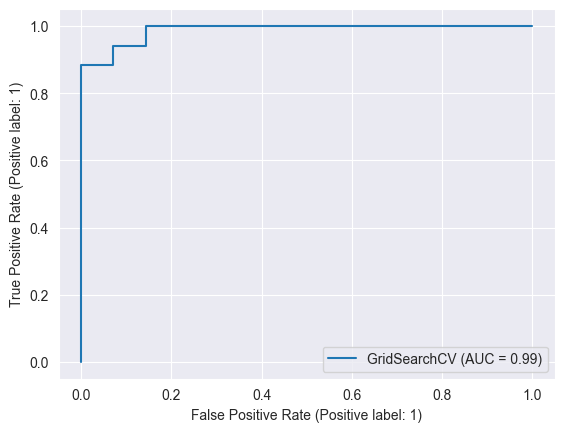

In [41]:
RocCurveDisplay.from_estimator(grid_model, X_test_scale, y_test);

### Кривые производительности для LogisticRegressionCV

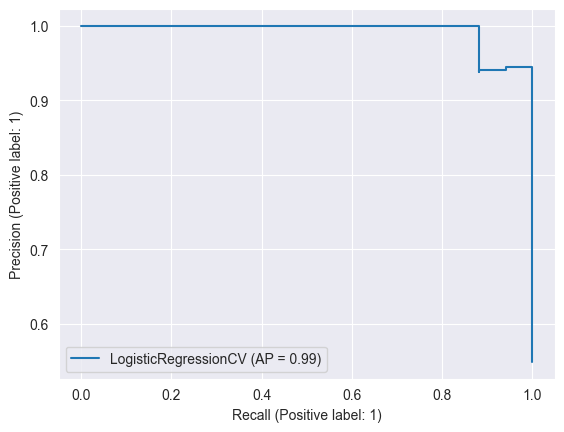

In [42]:
PrecisionRecallDisplay.from_estimator(log_cv_model, X_test_scale, y_test);

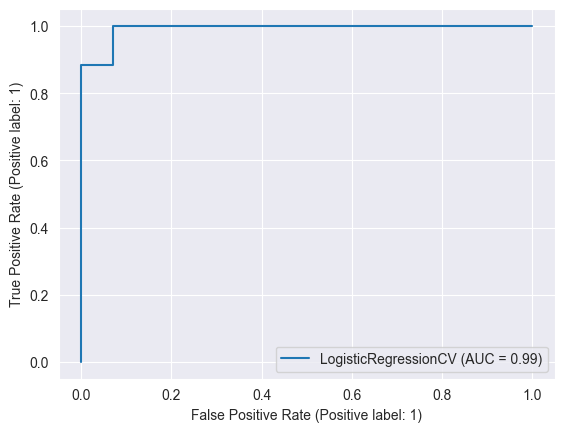

In [43]:
RocCurveDisplay.from_estimator(log_cv_model, X_test_scale, y_test);

**Представим, что в клинику пришёл пациент со следующими значениями признаков:**

    age          48.0
    sex           0.0
    cp            2.0
    trestbps    130.0
    chol        275.0
    fbs           0.0
    restecg       1.0
    thalach     139.0
    exang         0.0
    oldpeak       0.2
    slope         2.0
    ca            0.0
    thal          2.0

In [44]:
patient = [[54. , 1. , 0. , 122. , 286. , 0. , 0. , 116. , 1.,
          3.2, 1. , 2. ,2. ]]

**Предсказание класса GridSearchCV**

In [45]:
grid_model.predict(scaler.transform(patient))

array([0], dtype=int64)

**Предсказание класса LogisticRegressionCV**

In [46]:
log_cv_model.predict(patient)

array([0], dtype=int64)

**Этот пациент должен иметь класс 0, то есть у него нет заболеваний сердца, так что модели справились с этой задачей. Цель проекта достигнута.**